#  Introduction to ProtBERT

### Introduction

Proteins, the workhorses of cellular functions, are composed of unique sequences of amino acids that fold into intricate three-dimensional structures. These structures determine how proteins interact with other molecules, perform specific tasks within cells, and influence biological processes. Understanding protein sequences and their corresponding structures is fundamental to unraveling the molecular mechanisms underlying diseases, drug interactions, and evolutionary relationships.

In bioinformatics, deciphering the language of proteins is crucial for a wide array of applications. For instance, predicting the structure of proteins from their sequences remains one of the grand challenges in computational biology, with implications for drug design and personalized medicine. Furthermore, identifying functional domains within proteins helps researchers comprehend their roles in cellular processes and disease pathways.

ProtBERT represents a significant advancement in this field, harnessing the power of BERT (Bidirectional Encoder Representations from Transformers) for protein sequence analysis. By learning contextual representations of amino acid sequences, ProtBERT enables researchers to predict protein functions, classify proteins into different structural categories, and perform other complex tasks with high accuracy.

This tutorial introduces ProtBERT within the context of DeepChem, a comprehensive library for deep learning in chemistry and biology. You will learn how to harness ProtBERT's capabilities through pretraining on large-scale protein datasets and fine-tuning for specific tasks like protein classification and prediction. Through hands-on examples and practical exercises, you will gain the skills to apply ProtBERT in your own bioinformatics research, advancing our understanding of proteins and paving the way for groundbreaking discoveries in molecular biology.

By the end of this tutorial, you will not only appreciate the importance of protein sequence analysis but also be equipped with the knowledge and tools to leverage ProtBERT effectively, contributing to advancements in biomedical research and therapeutic development.


### Setup

#### Install necessary libraries


In [1]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 14.6 MB/s eta 0:00:00


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


'2.8.1.dev'

### Understanding ProtBERT

ProtBERT is a specialized variant of the BERT (Bidirectional Encoder Representations from Transformers) model, specifically designed for processing protein sequences. Developed by researchers at the Rostlab, ProtBERT leverages the transformative capabilities of BERT to encode the complex and nuanced features present in amino acid sequences.

#### Key Features of ProtBERT:

1. **BERT Architecture Adaptation:** ProtBERT adapts the original BERT architecture to the unique characteristics of protein sequences. It consists of transformer layers that capture both local and global dependencies in the sequence, making it suitable for tasks ranging from masked language modeling (MLM) to sequence classification.

2. **Tokenization and Embedding:** Similar to how BERT tokenizes words in natural language, ProtBERT tokenizes amino acids in protein sequences. It uses a specialized tokenizer trained on large protein sequence databases, enabling it to generate embeddings that capture the semantic meaning and context of amino acids.

3. **Pretraining and Fine-tuning:** ProtBERT supports pretraining on large-scale protein datasets such as UniRef100 and BFD (Baker's finite difference), which helps it learn representations that generalize well across diverse protein sequences. These pretrained models can then be fine-tuned for specific tasks like protein classification (e.g., predicting membrane proteins or subcellular localization).

4. **Task-specific Adaptation:** Depending on the task, ProtBERT can be adapted with different classifier heads. For instance, it can be configured for single-label or multi-label classification tasks, allowing researchers to tailor it to specific biological questions.


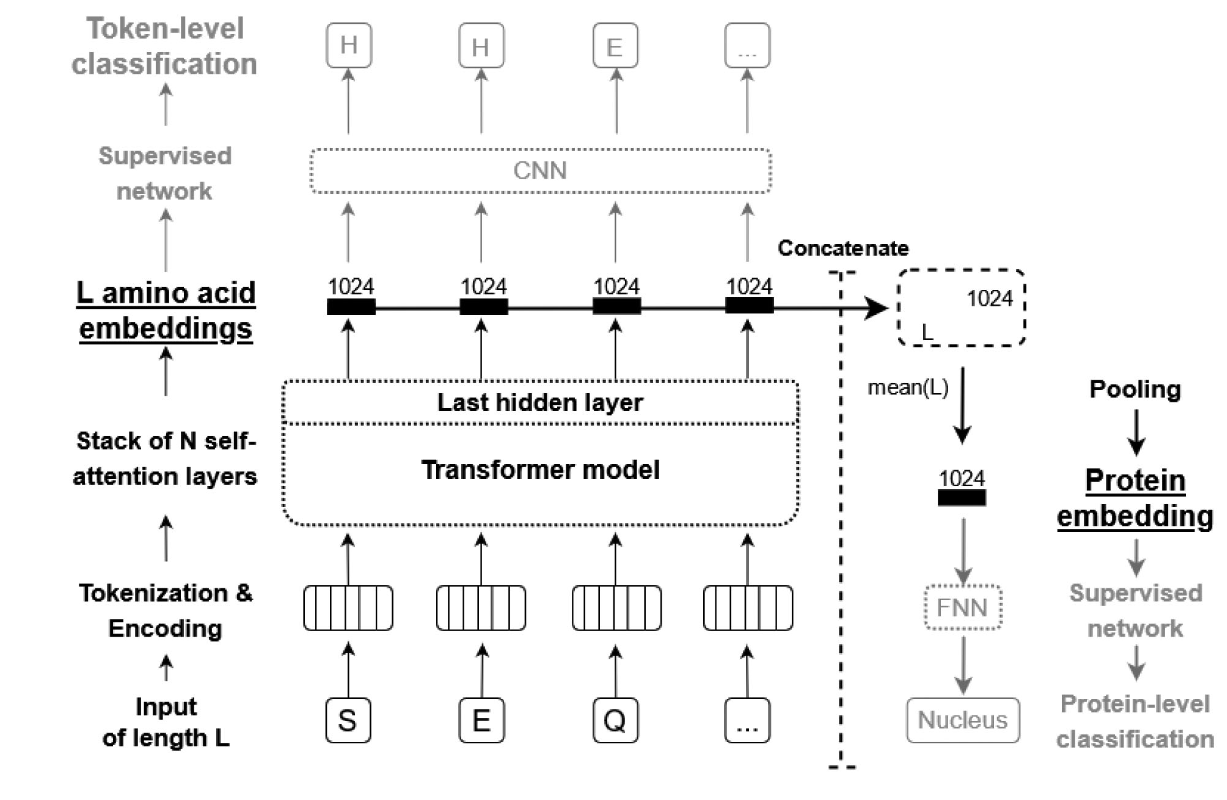

Image reference: Elnaggar, Ahmed, et al. "Prottrans: Toward understanding the language of life through self-supervised learning." IEEE transactions on pattern analysis and machine intelligence 44.10 (2021): 7112-7127.

### Loading ProtBERT

ProtBERT comes pretrained with models specifically trained on the Uniref100 and BFD (Baker's field dataset). These pretrained models are available for both Masked Language Modeling (MLM) and Sequence Classification tasks. This section covers how to load ProtBERT in different modes and details the pretrained datasets available.

#### Pretrained Models:

1. **Uniref100 Model:**
   - **Description:** The Uniref100 model is pretrained on a large, non-redundant dataset of protein sequences, offering a general-purpose model for protein language understanding.
   - **Usage:** Initialize ProtBERT with `model_pretrain_dataset='uniref100'` to load the Uniref100 pretrained model.

2. **BFD Model (Baker's field dataset):**
   - **Description:** The BFD model is pretrained on a large and diverse dataset, offering enhanced performance for tasks demanding detailed and specific protein annotations.
   - **Usage:** Initialize ProtBERT with `model_pretrain_dataset='bfd'` to load the BFD pretrained model.

#### Supported Modes:

1. **Masked Language Modeling (MLM):**
   - **Description:** ProtBERT learns to predict masked amino acids in protein sequences, facilitating deeper understanding of amino acid relationships and sequence contexts.
   - **Usage:** Initialize ProtBERT with `task='mlm'` and specify either `model_pretrain_dataset='uniref100'` or `model_pretrain_dataset='bfd'` for MLM tasks.

2. **Sequence Classification:**
   - **Description:** Enables classification tasks such as predicting membrane proteins, subcellular localization, or custom classifications using a user-defined classifier head.
   - **Usage:** Set `task='classification'` to utilize ProtBERT for sequence classification. Specify the `cls_task` parameter as 'membrane', 'subcellular location', or 'custom' for predefined or custom tasks.
     - **Predefined Tasks:** Use 'membrane' and 'subcellular location' with the BFD model.
     - **Custom Task:** Set `cls_task='custom'` and provide a custom classifier head using the `cls_head` argument. This allows users to define specific classification tasks independent of the pretrained datasets.



### Temporary cell until ProtBERT is merged

In [3]:
from transformers import BertForMaskedLM, BertForSequenceClassification, BertTokenizer, BertConfig
import torch.nn as nn
from deepchem.models.torch_models.hf_models import HuggingFaceModel
from typing import Union


class ProtBERT(HuggingFaceModel):
    """
    ProtBERT model[1].

    ProtBERT model is based on the BERT architecture and the current implementation
    supports only MLM pretraining and classification mode, as described by the
    authors in HuggingFace[2]. The classification mode supports three tasks:
    membrane protein prediction, subcellular localization prediction, and custom
    classification tasks with a user-provided classifier head.

    The model converts the input protein sequence into a vector through a trained BERT tokenizer, which is then
    processed by the corresponding model based on the task. `BertForMaskedLM` is used to facilitate the MLM
    pretraining task. For the sequence classification task, we follow `BertForSequenceClassification` but change
    the classifier to a custom `nn.Module` if provided.


    Examples
    --------
    >>> import os
    >>> import tempfile
    >>> tempdir = tempfile.mkdtemp()

    >>> # preparing dataset
    >>> import pandas as pd
    >>> import deepchem as dc
    >>> protein = ["MPCTTYLPLLLLLFLLPPPSVQSKV","SSGLFWMELLTQFVLTWPLVVIAFL"]
    >>> labels = [0,1]
    >>> df = pd.DataFrame(list(zip(protein, labels)), columns=["protein", "task1"])
    >>> with dc.utils.UniversalNamedTemporaryFile(mode='w') as tmpfile:
    ...     df.to_csv(tmpfile.name)
    ...     loader = dc.data.CSVLoader(["task1"], feature_field="protein", featurizer=dc.feat.DummyFeaturizer())
    ...     dataset = loader.create_dataset(tmpfile.name)

    >>> # pretraining
    >>> from deepchem.models.torch_models.prot_bert import ProtBERT
    >>> pretrain_model_dir = os.path.join(tempdir, 'pretrain-model')
    >>> model_path = 'Rostlab/prot_bert'
    >>> pretrain_model = ProtBERT(task='mlm', model_pretrain_dataset='uniref100', n_tasks=1, model_dir=pretrain_model_dir)  # mlm pretraining
    >>> pretraining_loss = pretrain_model.fit(dataset, nb_epoch=1)
    >>> del pretrain_model

    >>> finetune_model_dir = os.path.join(tempdir, 'finetune-model')
    >>> custom_torch_cls_seq_network = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(),nn.Linear(512, 2))
    >>> finetune_model = ProtBERT(task='classification', model_pretrain_dataset='uniref100', n_tasks=1,cls_task="custom",cls_head=custom_torch_cls_seq_network, model_dir=finetune_model_dir)
    >>> finetune_model.load_from_pretrained(pretrain_model_dir)
    >>> finetuning_loss = finetune_model.fit(dataset, nb_epoch=1)

    >>> # prediction and evaluation
    >>> result = finetune_model.predict(dataset)
    >>> eval_results = finetune_model.evaluate(dataset, metrics=dc.metrics.Metric(dc.metrics.accuracy_score))

    References
    ----------
    .. [1] Elnaggar, Ahmed, et al. "Prottrans: Toward understanding the language of life through self-supervised learning." IEEE transactions on pattern analysis and machine intelligence 44.10 (2021): 7112-7127.
    .. [2] https://huggingface.co/Rostlab/prot_bert

    """

    def __init__(self,
                 task: str,
                 model_pretrain_dataset: str = "uniref100",
                 n_tasks: int = 1,
                 cls_task: str = "custom",
                 cls_head: Union[nn.Module, None] = None,
                 n_classes: int = 2,
                 **kwargs) -> None:
        """
        Parameters
        ----------
        task: str
            The task defines the type of learning task in the model. The supported tasks are:
            - `mlm` - masked language modeling commonly used in pretraining
            - `classification` - use it for classification tasks
        model_pretrain_dataset: str
            The dataset used for pretraining the model. Options are 'uniref100' and 'bfd'.
        n_tasks: int, default 1
            Number of prediction targets for a multitask learning model
        cls_task: str, default "custom"
            The specific classification task. Options are "membrane", "subcellular location", and "custom".
        cls_head: nn.Module, optional
            A custom classifier head to use for classification mode.
        n_classes: int, default 2
            Number of classes for classification.
        """

        self.n_tasks: int = n_tasks

        if model_pretrain_dataset == "uniref100":
            model_path = 'Rostlab/prot_bert'
        elif model_pretrain_dataset == "bfd":
            model_path = 'Rostlab/prot_bert_bfd'
        else:
            raise ValueError('Invalid pretraining dataset: {}.'.format(
                model_pretrain_dataset))

        tokenizer = BertTokenizer.from_pretrained(model_path,
                                                  do_lower_case=False)

        if task == "mlm":
            model = BertForMaskedLM.from_pretrained(model_path)
        elif task == "classification":
            if model_pretrain_dataset == "uniref100" and cls_task in [
                    "membrane", "subcellular location"
            ]:
                raise ValueError(
                    "Classification model for '{}' task is only available with BFD pretraining dataset."
                    .format(cls_task))

            if cls_task == "membrane":
                if cls_head is not None:
                    raise ValueError(
                        "Custom classifier head is not supported for 'membrane' task."
                    )
                model = BertForSequenceClassification.from_pretrained(
                    'Rostlab/prot_bert_bfd_membrane')

            elif cls_task == "subcellular location":
                if cls_head is not None:
                    raise ValueError(
                        "Custom classifier head is not supported for 'subcellular location' task."
                    )
                model = BertForSequenceClassification.from_pretrained(
                    'Rostlab/prot_bert_bfd_localization')

            elif cls_task == "custom":
                if isinstance(cls_head, nn.Module):
                    cls_net = cls_head
                else:
                    raise ValueError(
                        'Invalid classifier head type. Expected nn.Module but got {}.'
                        .format(type(cls_head)))

                protbert_config = BertConfig.from_pretrained(
                    pretrained_model_name_or_path=model_path,
                    vocab_size=tokenizer.vocab_size)
                protbert_config.num_labels = n_classes

                if n_tasks == 1:
                    protbert_config.problem_type = 'single_label_classification'
                else:
                    protbert_config.problem_type = 'multi_label_classification'

                model = BertForSequenceClassification.from_pretrained(
                    model_path, config=protbert_config)
                model.classifier = cls_net

            else:
                raise ValueError(
                    'Invalid classification task: {}. Expected "membrane", "subcellular location", or "custom".'
                    .format(cls_task))
        else:
            raise ValueError(
                'Invalid task specification: {}. Expected "mlm" or "classification".'
                .format(task))

        super().__init__(model=model, task=task, tokenizer=tokenizer, **kwargs)


## Importing Model

In [4]:
# Load ProtBERT

pretrain_model_dir = "pretraining/"
finetune_model_dir = "finetuning/"
ProtBERTmodel_for_pretraining = ProtBERT(task='mlm', model_pretrain_dataset="bfd", n_tasks=1, model_dir=pretrain_model_dir) # ProtBERT model that can be used pretraining on a custom dataset, model weights are loaded with ProtBERT pretrained on BFD dataset


custom_network = nn.Sequential(nn.Linear(1024, 512),
                               nn.ReLU(), nn.Linear(512, 256),
                               nn.ReLU(), nn.Linear(256, 2)) # Network for custom classfication task

ProtBERTmodel_for_classification = ProtBERT(task='classification',
                                            model_pretrain_dataset="bfd",
                                            cls_task="custom",
                                            cls_head=custom_network,
                                            n_tasks=1,
                                            n_classes=2,
                                            model_dir=finetune_model_dir,
                                            batch_size=1,
                                            learning_rate=1e-5) # ProtBERT model that can be used for fine-tuning for a downstream task


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_bert_bfd and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Pretraining ProtBERT

ProtBERT undergoes pretraining on extensive protein sequence datasets like Uniref100 and BFD using Masked Language Modeling (MLM). MLM is a common technique in language modeling where random tokens in the input sequence are masked, and the model learns to predict these masked tokens based on the context provided by the surrounding tokens. This approach helps ProtBERT understand the intricate language of proteins, uncovering complex patterns and relationships within amino acid sequences.


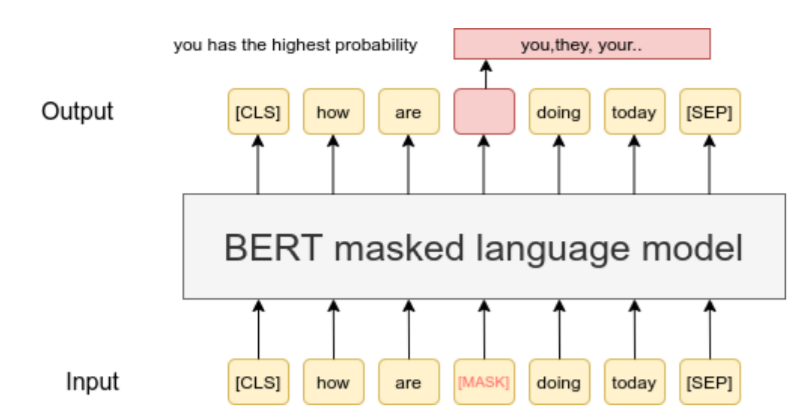

Image reference: https://www.sbert.net/examples/unsupervised_learning/MLM/README.html

In [5]:
# Pretraining code
import pandas as pd
import deepchem as dc

n_epochs = 1
loader = dc.data.CSVLoader([],
                            feature_field="protein",
                            featurizer=dc.feat.DummyFeaturizer())
pretraining_dataset = loader.create_dataset("assets/protbert_data/sample_pretraining_proteins.csv")

loss = ProtBERTmodel_for_pretraining.fit(pretraining_dataset, nb_epoch=n_epochs)

### Fine-Tuning ProtBERT

Fine-tuning ProtBERT involves adapting the pretrained model to specific tasks or datasets, such as protein classification, subcellular localization prediction, or custom tasks. This process is crucial because it leverages the knowledge gained during pretraining on large datasets like Uniref100 or BFD. By fine-tuning, researchers can enhance ProtBERT's performance on targeted tasks without starting from scratch, thus accelerating model deployment and improving accuracy in biomedical applications.


In [6]:
# ProtBERTmodel_for_classification.load_from_pretrained(pretrain_model_dir) # Skip this step if you are not pretraining

n_epochs = 50
loader = dc.data.CSVLoader(["outcome"],
                            feature_field="protein",
                            featurizer=dc.feat.DummyFeaturizer())
finetuning_dataset = loader.create_dataset("assets/protbert_data/sample_protein_classification.csv")
loss = ProtBERTmodel_for_classification.fit(finetuning_dataset, nb_epoch = n_epochs)


### Evaluation and Prediction

After training or fine-tuning, evaluate ProtBERT's performance using metrics like accuracy.


In [7]:
classification_metric = dc.metrics.Metric(dc.metrics.accuracy_score)
eval_score = ProtBERTmodel_for_classification.evaluate(finetuning_dataset,
                                                 [classification_metric])

eval_score # Since we are training and testing on the same dataset we get a perfect accuracy

{'accuracy_score': 1.0}